In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Pre-Modeling

#### Assemble the data

In [99]:
bidders = pd.read_csv("./Resources/bidders.csv", index_col =False)
country_merch = pd.read_csv("./Resources/bidders_count_merch.csv", index_col =False)
bidder_auc = pd.read_csv("./Resources/bidder_auc.csv")
bidder_auc_cm = pd.read_csv("./Resources/bidder_auc_cm.csv")
train = pd.read_csv("./Resources/train.csv")

# bidders = bidders.merge(country_merch, right_index=True, left_index=True)
# bidders = bidders.merge(bidder_auc, right_index=True, left_index=True)
# bidders = bidders.merge(bidder_auc_cm, right_index=True, left_index=True)

print(bidders.shape)
bidders.head()

(6609, 10)


,bidder_id,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,time_mean,time_median,time_std
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,0.000000e+00,0.000000e+00,0.000000e+00
1,002d229ffb247009810828f648afc2ef593rb,1,1,2,1,1,1,1.052632e+08,1.052632e+08,0.000000e+00
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,0.000000e+00,0.000000e+00,0.000000e+00
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,1,3,1,3,2,3.297784e+13,3.297784e+13,3.904443e+13
4,00486a11dff552c4bd7696265724ff81yeo9v,13,1,8,1,10,7,4.018413e+12,9.177368e+11,1.153730e+13


In [100]:
# merged_bidders = train.merge(bidders, how= "left", on="bidder_id")
# Since the bidders who never bid are all human, just ignore them with inner join 
merged_bidders = train.merge(bidders, how= "inner", on="bidder_id")

print(merged_bidders.shape)
merged_bidders.head()

(1983, 13)


,bidder_id,payment_account,address,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,time_mean,time_median,time_std
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18,1,14,6,20,1,5.711121e+11,3.458421e+11,7.438736e+11
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1,1,2,1,3,2,3.233579e+12,3.233579e+12,1.759654e+12
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4,1,2,1,4,2,2.379000e+12,2.532053e+12,8.618847e+11
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1,1,1,1,1,0.000000e+00,0.000000e+00,0.000000e+00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23,1,53,2,123,91,7.777888e+10,1.368421e+10,2.154285e+11


Since each bidder in train dataset has corresponding unique payment account and address, and bidder_id is also a unique id that won't be useful for machine lerning. <br>
These three columns could be dropped.

In [101]:
merged_bidders = merged_bidders.drop(columns=["bidder_id", "payment_account", "address"])
print(merged_bidders.shape)
merged_bidders.head()

(1983, 10)


,outcome,auction_count,merchandise_count,device_count,country_count,ip_count,url_count,time_mean,time_median,time_std
0,0.0,18,1,14,6,20,1,5.711121e+11,3.458421e+11,7.438736e+11
1,0.0,1,1,2,1,3,2,3.233579e+12,3.233579e+12,1.759654e+12
2,0.0,4,1,2,1,4,2,2.379000e+12,2.532053e+12,8.618847e+11
3,0.0,1,1,1,1,1,1,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,23,1,53,2,123,91,7.777888e+10,1.368421e+10,2.154285e+11


In [102]:
# Check the null value
merged_bidders.isnull().sum()

outcome              0
auction_count        0
merchandise_count    0
device_count         0
country_count        0
ip_count             0
url_count            0
time_mean            0
time_median          0
time_std             0
dtype: int64

In [343]:
# Fill the bidder who never bids with the average value of the dataframe
merged_bidders.fillna(merged_bidders.mean(), inplace=True)

In [344]:
merged_bidders.isnull().sum()

outcome                    0
auction_nunique_num        0
merchandise_nunique_num    0
device_nunique_num         0
country_nunique_num        0
                          ..
country_pr                 0
country_mo                 0
country_gy                 0
country_tm                 0
country_gl                 0
Length: 189, dtype: int64

If only use bidders.csv to train the model and get the importances, merchandise_count has 0 important score. Therefore, it should be drop for further analysis.

	Features	Feature Score<br>
0.	time_median	   0.241426 <br>
1.	time_mean	   0.221284<br>
2.	auction_count	0.130564<br>
3.	ip_count	    0.114091<br>
4.	time_std	    0.106800<br>
5.	device_count	0.066883<br>
6.	url_count	0.064681<br>
7.	country_count	0.054271<br>
8.	merchandise_count	0.000000<br>

In [171]:
#  drop merchandise_count
merged_bidders = merged_bidders.drop(columns=["merchandise_count"])
# merged_bidders = merged_bidders.drop(columns=["merchandise_count_x", "merchandise_count_y"])
print(merged_bidders.shape)
merged_bidders.head()

(1983, 9)


,outcome,auction_count,device_count,country_count,ip_count,url_count,time_mean,time_median,time_std
0,0.0,18,14,6,20,1,5.711121e+11,3.458421e+11,7.438736e+11
1,0.0,1,2,1,3,2,3.233579e+12,3.233579e+12,1.759654e+12
2,0.0,4,2,1,4,2,2.379000e+12,2.532053e+12,8.618847e+11
3,0.0,1,1,1,1,1,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,23,53,2,123,91,7.777888e+10,1.368421e+10,2.154285e+11


In [15]:
# merged_bidders.to_csv("./Resources/merged_bidders.csv", index=False)

#### Spilt and scale the data

In [172]:
# Split our preprocessed data into features and target arrays
y = merged_bidders["outcome"].values
X = merged_bidders.drop(columns= "outcome", axis= 1).values

# Split the preprocessed data into a training and testing dataset
# Default
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Customize the split size
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.5)

In [173]:
# Create a Scaler instances: Try two scaler
scaler = StandardScaler()
# scaler = MinMaxScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Balanced RandomForest Classifier

In [174]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=250, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.8519639934533552
Confusion Matrix


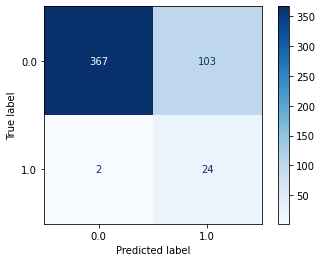

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.78      0.92      0.87      0.85      0.71       470
        1.0       0.19      0.92      0.78      0.31      0.85      0.73        26

avg / total       0.95      0.79      0.92      0.85      0.85      0.71       496



In [175]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

In [176]:
# List the features sorted in descending order by feature importance
x = merged_bidders.drop(columns= "outcome", axis= 1)
import_score = model.fit(X_train, y_train).feature_importances_
import_rank = sorted(zip(import_score, x.columns), reverse=True)
importances = pd.DataFrame(import_rank, columns=["Feature Score", "Features"])
importances = importances[["Features", "Feature Score"]]
importances.head(10)

,Features,Feature Score
0,time_mean,0.217142
1,time_median,0.208423
2,auction_count,0.135815
3,ip_count,0.111009
4,time_std,0.104005
5,device_count,0.091756
6,url_count,0.077560
7,country_count,0.054290


#### Easy Ensemble Classifier

In [177]:
from imblearn.ensemble import EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=200 ,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.8540916530278233
Confusion Matrix


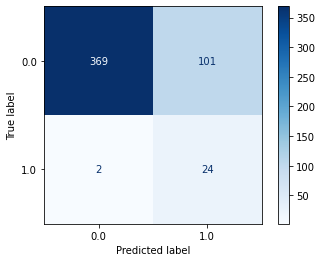

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.79      0.92      0.88      0.85      0.71       470
        1.0       0.19      0.92      0.79      0.32      0.85      0.73        26

avg / total       0.95      0.79      0.92      0.85      0.85      0.72       496



In [178]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

#### Gradient Boosting Classifier

In [179]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=200, random_state= 42, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.6047463175122749
Confusion Matrix


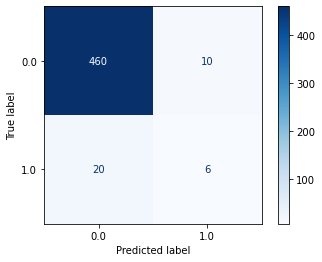

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.98      0.23      0.97      0.48      0.24       470
        1.0       0.38      0.23      0.98      0.29      0.48      0.21        26

avg / total       0.93      0.94      0.27      0.93      0.48      0.24       496



In [180]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

#### Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [183]:
model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42, bootstrap=True, oob_score=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.5192307692307693
Confusion Matrix


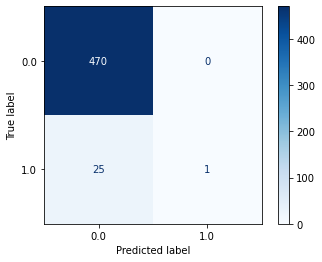

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      1.00      0.04      0.97      0.20      0.04       470
        1.0       1.00      0.04      1.00      0.07      0.20      0.03        26

avg / total       0.95      0.95      0.09      0.93      0.20      0.04       496



In [184]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

#### Ada Boost Classifier

In [185]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.5844517184942717
Confusion Matrix


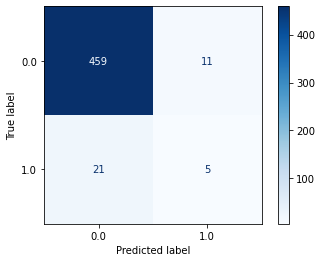

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.98      0.19      0.97      0.43      0.20       470
        1.0       0.31      0.19      0.98      0.24      0.43      0.17        26

avg / total       0.92      0.94      0.23      0.93      0.43      0.20       496



In [186]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

### Submission

In [326]:
test = pd.read_csv("./Resources/test.csv")

In [327]:
merged_test = test.merge(bidders, how= "left", on="bidder_id")
merged_test.head()

,bidder_id,payment_account,address,auction_nunique_num,merchandise_nunique_num,device_nunique_num,country_nunique_num,ip_nunique_num,url_nunique_num,time_mean,...,country_zz,country_bs,country_aw,country_gb,country_vi,country_mh,country_tc,country_an,country_er,country_gp
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c,3.0,1.0,2.0,3.0,4.0,3.0,2.340789e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn,2.0,1.0,3.0,2.0,2.0,1.0,3.800103e+13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0,14.0,1.0,4.0,3.0,4.0,2.0,1.819079e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat,90.0,1.0,81.0,14.0,129.0,80.0,5.205553e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa,20.0,1.0,17.0,2.0,17.0,1.0,2.988541e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [328]:
test_id = merged_test["bidder_id"]

In [329]:
merged_test.fillna(merged_test.mean(), inplace=True)

C:\Users\Jarvinia\AppData\Local\Temp\ipykernel_19324\3694548704.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_test.fillna(merged_test.mean(), inplace=True)


In [330]:
merged_test.isnull().sum()

bidder_id                  0
payment_account            0
address                    0
auction_nunique_num        0
merchandise_nunique_num    0
                          ..
country_mh                 0
country_tc                 0
country_an                 0
country_er                 0
country_gp                 0
Length: 220, dtype: int64

In [331]:
merged_test = merged_test.drop(columns=["bidder_id", "payment_account", "address"])
merged_test.head()

,auction_nunique_num,merchandise_nunique_num,device_nunique_num,country_nunique_num,ip_nunique_num,url_nunique_num,time_mean,time_median,merchandise_jewelry,merchandise_furniture,...,country_zz,country_bs,country_aw,country_gb,country_vi,country_mh,country_tc,country_an,country_er,country_gp
0,3.0,1.0,2.0,3.0,4.0,3.0,2.340789e+13,5.781053e+12,743.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,3.0,2.0,2.0,1.0,3.800103e+13,3.800103e+13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.0,1.0,4.0,3.0,4.0,2.0,1.819079e+10,2.315789e+09,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90.0,1.0,81.0,14.0,129.0,80.0,5.205553e+11,1.046842e+11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.0,1.0,17.0,2.0,17.0,1.0,2.988541e+11,8.131579e+09,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [332]:
test_scaled = StandardScaler().fit_transform(merged_test)

In [333]:
pred = model.predict(test_scaled)

In [334]:
pred

array([0., 1., 1., ..., 1., 1., 1.])

In [335]:
submission = pd.read_csv("./Resources/sampleSubmission.csv")
result = pd.DataFrame({"bidder_id": test_id, "predicts": pred})
final_sub = submission.merge(result, on="bidder_id", how= "left")
final_sub = final_sub.drop(columns= "prediction", axis = 1)

In [336]:
final_sub["predicts"].value_counts()

1.0    4366
0.0     334
Name: predicts, dtype: int64

In [337]:
final_sub.isnull().sum()

bidder_id    0
predicts     0
dtype: int64

In [338]:
final_sub.to_csv("Final_results.csv", index=False, header=["bidder_id", "prediction"])